<a href="https://colab.research.google.com/github/VIVEK-JADHAV/All-State-Claim-Severity/blob/master/AllStateClaimEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVR
import pickle
from sklearn.metrics import mean_absolute_error
from  sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold



In [ ]:
#Creating a folder to store train and test data
import os
os.mkdir('/content/data')
%cd /content/data/
!pwd

/content/data
/content/data


In [ ]:
#Downloading data from kaggle
!kaggle competitions download -c allstate-claims-severity -f train.csv
!kaggle competitions download -c allstate-claims-severity -f test.csv

 62% 9.00M/14.6M [00:00<00:00, 25.4MB/s]
100% 14.6M/14.6M [00:00<00:00, 33.0MB/s]
 55% 5.00M/9.12M [00:00<00:00, 18.5MB/s]
100% 9.12M/9.12M [00:00<00:00, 30.4MB/s]


In [ ]:
! unzip train.csv.zip 
! unzip test.csv.zip 

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


## EDA  


In [ ]:
train=pd.read_csv('/content/data/train.csv')
print('Shape of the train data is ',train.shape)
train.head()

Shape of the train data is  (188318, 132)


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


* Train dataset has 188318 datapoints and 132 features.

In [ ]:
test=pd.read_csv('/content/data/test.csv')
print('Shape of the test data is ',test.shape)
test.head()

Shape of the test data is  (125546, 131)


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,C,C,E,C,D,T,H,G,A,A,G,E,I,L,K,BI,BC,A,J,AX,A,Q,HG,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,D,D,E,A,A,P,B,D,A,A,G,G,G,F,B,BI,CO,E,G,X,A,L,HK,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,B,A,B,B,B,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,...,A,A,D,D,C,E,E,A,D,G,Q,A,D,D,E,J,G,A,BI,CS,C,U,AE,A,K,CK,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,...,G,H,D,D,C,E,E,D,T,G,A,A,D,E,E,I,K,K,BI,CR,A,AY,AJ,A,P,DJ,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,A,D,B,D,E,A,A,P,A,A,A,A,F,E,G,E,B,AB,EG,A,E,I,C,J,HA,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


* Test dataset has 125546 datapoints and 131 features.

In [ ]:
#Number of categorical and numerical features in train and test dataset
train_columns=train.columns.values
test_columns=test.columns.values

def feature_count(columns):
  '''Returns count of categorical and contineous features'''
  cat_fetures=0
  cont_features=0
  for i in columns:
    if('cat' in i):
      cat_fetures+=1
    elif('cont' in i):
      cont_features+=1
  return cat_fetures,cont_features

train_cat,train_cont=feature_count(train_columns)
test_cat,test_cont=feature_count(test_columns)

print('Number of categorical features is {} and contineous features is {} in train dataset'.format(train_cat,train_cont))
print('Number of categorical features is {} and contineous features is {} in test dataset'.format(test_cat,test_cont))

Number of categorical features is 116 and contineous features is 14 in train dataset
Number of categorical features is 116 and contineous features is 19 in test dataset


* Both have 116 masked categorical features and 14 masked contineous features with Loss feature in train dataset.

In [ ]:
#Count of Null and NAN values

no_nan=train.isna().sum().sum()
no_null=train.isnull().sum().sum()
print('Number of NAN values are {}'.format(no_nan))
print('Number of null values are {}'.format(no_null))

Number of NAN values are 0
Number of null values are 0


* There are no null or NAN values in the train dataset.

### TARGET VARIABLE

In [ ]:
#Range of the loss value
train.loss.describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

* Assuming that the loss value is in dollar, minimum claim value is  \$0.67 and maximum claim value is \$121,012. 

In [ ]:
#Sorting loss value in ascending order
train.loss.sort_values()

144838         0.67
92922          5.25
102710         6.00
55422          8.40
10331         10.00
            ...    
81475      67667.16
172883     79623.52
14969      85923.56
83871     106863.00
53551     121012.25
Name: loss, Length: 188318, dtype: float64

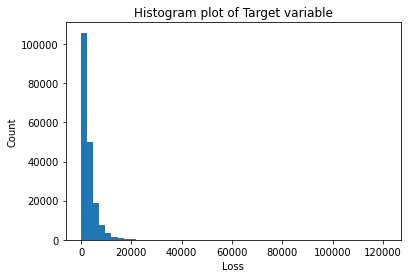

In [ ]:
#Histogram plot of Target variable
plt.hist(train['loss'],bins=50)
plt.xlabel('Loss')
plt.ylabel('Count')
plt.title('Histogram plot of Target variable')
plt.show()

* Almost all the loss value lies less than 20,000 units and very few above it, making it a right skewed variable.
* This has to be corrected as the model would perform well on high count values and poorly on low count values.
* One solution is to apply log transform

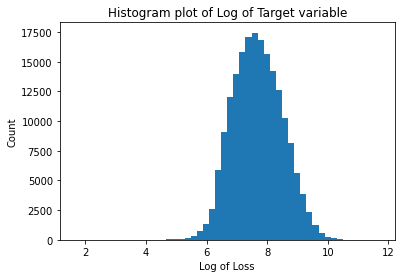

In [ ]:
#Histogram plot of Log of Target variable
plt.hist(np.log(train['loss']),bins=50)
plt.xlabel('Log of Loss')
plt.ylabel('Count')
plt.title('Histogram plot of Log of Target variable')
plt.show()

* After log transformation, the loss variable looks like normally distributed with truncated tails.

#### CHECK WHETHER TRAIN AND TEST DATA HAVE SAME DISTRIBUTION

In [ ]:
#Creating new Dataframe with train data having class label 1 and test data with 0
new_train=train.drop(columns=['loss'])
new_train['Class']=1

new_test=test.copy()
new_test['Class']=0

new_df=pd.concat([new_train,new_test])
new_df.shape

(313864, 132)

In [ ]:
#Performing train-test split
 
X_tr,X_te,y_tr,y_te=train_test_split(new_df.drop(['id','Class'],axis=1),new_df['Class'],test_size=0.2,
                                     stratify=new_df['Class'],random_state=20)
print(X_tr.shape,X_te.shape)
print(y_tr.shape,y_te.shape)

(251091, 130) (62773, 130)
(251091,) (62773,)


In [ ]:
#OneHotEncodeing of categorical features and mergging with numerical features

oe=OneHotEncoder(handle_unknown='ignore')
X_tr_cat=oe.fit_transform(X_tr.iloc[:,0:116])
X_te_cat=oe.transform(X_te.iloc[:,0:116])

a=np.array(X_tr.iloc[:,116:])
X_tr_full=np.concatenate((a,X_tr_cat.todense()),axis=1)

b=np.array(X_te.iloc[:,116:])
X_te_full=np.concatenate((b,X_te_cat.todense()),axis=1)

print('The shape of train data after one hot encoding is ',X_tr_full.shape)

print('The shape of test data after one hot encoding is ',X_te_full.shape)



The shape of train data after one hot encoding is  (251091, 1166)
The shape of test data after one hot encoding is  (62773, 1166)


In [ ]:
#Performing GridSearchCV to find best Hyperparameter for Logistic Regression

lr_model=SGDClassifier(loss='log')
params={'alpha':[0.001,0.01,0.1,1,10,100]}
clf=GridSearchCV(lr_model,params,cv=3,return_train_score=True)
clf.fit(X_tr_full,y_tr)

GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [ ]:
clf.best_params_

{'alpha': 0.001}

In [ ]:
#Creating a new model with best hyperparameter

new_model=SGDClassifier(loss='log',alpha=0.001)
new_model.fit(X_tr_full,y_tr)
y_pred=new_model.predict(X_te_full)

In [ ]:
#Predicting the class label on test dataset

accuracy=accuracy_score(y_te,y_pred)
print('The accuracy of the model is ',accuracy)

The accuracy of the model is  0.6000031860831886


In [ ]:
#Percent of class label 1 predicted by the classifier
no_ones=y_pred.sum()
print('The percentage of ones predicted is ',no_ones*100/X_te_full.shape[0])

The percentage of ones predicted is  100.0


* The model is predicting all the datapoints as 1. This tells that classifier is not able to distinguish between train and test data, indicating they are from same distribution.

### CATEGORICAL FEATURES

In [ ]:
#Reference:https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe
#Creating a dataframe with number of unique value in each categorical feature

cat_df=pd.DataFrame(columns=['Feature','Count'])
for i in range(1,len(train_columns[1:118])):
  cat_df.loc[i]=[train_columns[i]]+[len(train.iloc[:,i].unique())]
cat_df.head() 



,Feature,Count
1,cat1,2
2,cat2,2
3,cat3,2
4,cat4,2
5,cat5,2


In [ ]:
#Count of categorical features having having different unique values

d=dict(cat_df.Count.value_counts())
d=dict(sorted(d.items(),key=lambda k: k[0]))
keys=list(d.keys())
values=list(d.values())

number_df=pd.DataFrame({'No. of Unique Values':keys,'Count of features':values})
print(number_df)

    No. of Unique Values  Count of features
0                      2                 72
1                      3                  4
2                      4                 12
3                      5                  3
4                      7                  4
5                      8                  3
6                      9                  1
7                     11                  1
8                     13                  1
9                     15                  1
10                    16                  2
11                    17                  2
12                    19                  2
13                    20                  2
14                    23                  1
15                    51                  1
16                    61                  1
17                    84                  1
18                   131                  1
19                   326                  1


* Most of the categorical features have 2 categories but there is also a feature that has 326 different categories

In [ ]:
#Creating a Dataframe with count of categories in Binary Categorical Features
cat_cols=[i for i in train.columns if 'cat' in i]
binary_df=pd.DataFrame(columns=['A','B','Name','Percent of B','Percent of A'])
for i in range(0,len(cat_cols[0:72])):
  a=train[cat_cols[i]].value_counts()
  binary_df.loc[i,'A']=a['A']
  binary_df.loc[i,'B']=a['B']
  binary_df.loc[i,'Name']=cat_cols[i]
  binary_df.loc[i,'Percent of B']=a['B']*100/(a['A']+a['B'])
  binary_df.loc[i,'Percent of A']=a['A']*100/(a['A']+a['B'])


In [ ]:
#Filtering the binary features which has category count less than 1%
binary_df[binary_df['Percent of B']<0.1]

,A,B,Name,Percent of B,Percent of A
14,188284,34,cat15,0.0180546,99.9819
21,188275,43,cat22,0.0228337,99.9772
54,188173,145,cat55,0.0769974,99.923
55,188136,182,cat56,0.096645,99.9034
61,188273,45,cat62,0.0238958,99.9761
62,188239,79,cat63,0.0419503,99.958
63,188271,47,cat64,0.0249578,99.975
67,188176,142,cat68,0.0754044,99.9246
69,188295,23,cat70,0.0122134,99.9878


In [ ]:
#Filtering the binary features which has category count less than 1%
binary_df[binary_df['Percent of A']<0.1]

,A,B,Name,Percent of B,Percent of A


* The above binary categorical features have category 'B' less than 1% of all data points.
* These features do not seem to add much value to the final model. 

In [ ]:
#List of features to be removed
drop_features=list(binary_df.Name[binary_df['Percent of B']<0.1])

In [ ]:
#Features with 3 categories
cat_df[cat_df.Count==3]

,Feature,Count
73,cat73,3
74,cat74,3
75,cat75,3
76,cat76,3


In [ ]:
#Creating a Dataframe with count of categories for  Ternary Categorical Features
ternary_df=pd.DataFrame(columns=['A','B','C','Name','PercentA','PercentB','PercentC'])
for i in range(72,76):
  a=train[cat_cols[i]].value_counts()  
  ternary_df.loc[i,'A']=a['A']
  ternary_df.loc[i,'B']=a['B']
  ternary_df.loc[i,'C']=a['C']
  total=a['A']+a['B']+a['C']
  ternary_df.loc[i,'Name']=cat_cols[i]
  ternary_df.loc[i,'PercentA']=a['A']*100/total
  ternary_df.loc[i,'PercentB']=a['B']*100/total
  ternary_df.loc[i,'PercentC']=a['C']*100/total

In [ ]:
ternary_df

,A,B,C,Name,PercentA,PercentB,PercentC
72,154275,34016,26,cat73,81.923,18.0632,0.0138065
73,184730,3561,26,cat74,98.0952,1.89096,0.0138065
74,154306,34010,1,cat75,81.9395,18.06,0.00053102
75,181346,6183,788,cat76,96.2983,3.28329,0.418443


* Category 'C' is very low in number when compared to Category 'B' and Category 'A'.
* cat74 has 98% of data for Category 'A'. This feature does not add much value, hence can be removed

In [ ]:
#Features with 4 categories
cat_df[cat_df.Count==4]

,Feature,Count
77,cat77,4
78,cat78,4
79,cat79,4
80,cat80,4
81,cat81,4
82,cat82,4
83,cat83,4
84,cat84,4
85,cat85,4
86,cat86,4


In [ ]:
#Creating a Dataframe with count of categories for  4 Categorical Features
four_df=pd.DataFrame(columns=['C1','C2','C3','C4','Name','Percent1','Percent2','Percent3','Percent4'])
for i in range(76,88):
  a=train[cat_cols[i]].value_counts()   
  for j in range(1,5):
    four_df.loc[i,'C'+str(j)]=a[j-1]
  
  four_df.loc[i,'Name']=cat_cols[i]
  total=a[0]+a[1]+a[2]+a[3]
  for j in range(1,5):
    four_df.loc[i,'Percent'+str(j)]=a[j-1]*100/total 
 

In [ ]:
four_df.sort_values('Percent1')

,C1,C2,C3,C4,Name,Percent1,Percent2,Percent3,Percent4
85,103852,72587,10290,1589,cat86,55.1471,38.5449,5.46416,0.843786
79,137505,46538,3492,783,cat80,73.0174,24.7125,1.85431,0.415786
82,141534,26038,15788,4958,cat83,75.1569,13.8266,8.38369,2.63278
81,147536,19322,18805,2655,cat82,78.3441,10.2603,9.98577,1.40985
78,152929,26657,7064,1668,cat79,81.2079,14.1553,3.7511,0.885736
80,154385,24132,9013,788,cat81,81.981,12.8145,4.78605,0.418441
83,154939,29450,3498,431,cat84,82.2752,15.6384,1.8575,0.228868
86,166992,11719,8819,788,cat87,88.6755,6.22298,4.68304,0.418441
87,168926,19302,83,7,cat88,89.7025,10.2497,0.0440744,0.00371712
84,186005,1011,788,514,cat85,98.7718,0.536858,0.418441,0.272943


* Even in the features with four categories, one category is present high in number than the other.
* cat85,cat78 and cat77 have more than 98% of values with one category.These features does not seem to add much value.

In [ ]:
def categorical_plot(col):
  '''Plots countplot and boxplot for categorical features '''
  fig,ax=plt.subplots(1,2,figsize=(12,5))
  ax0=sns.countplot(x=col,data=train,order=sorted(train[col].unique()),ax=ax[0])
  ax0.set_title('Countplot for {} feature'.format(col))

  ax1=sns.boxplot(x=col,y=np.log(train['loss']),data=train,order=sorted(train[col].unique()),ax=ax[1])
  ax1.set_ylabel('Log of loss')
  ax1.set_title('Boxplot for {} feature'.format(col))

  plt.tight_layout(w_pad=6)
  plt.show()
  a=train[col].value_counts()
  print(a)
  print('Percent of majority category is ',a.max()*100/a.sum())



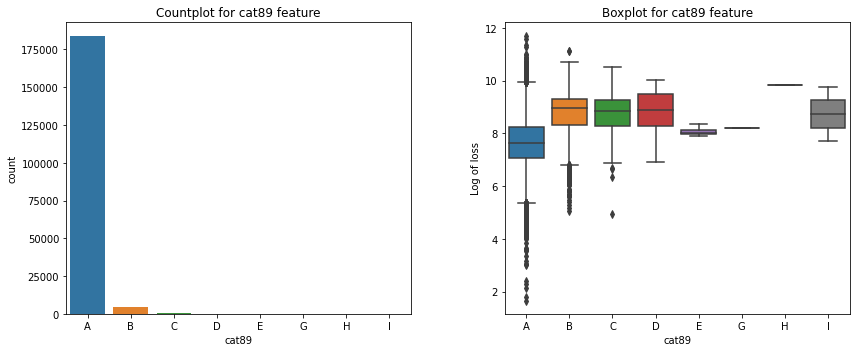

A    183743
B      4312
C       220
D        33
E         5
I         2
H         1
G         1
Name: cat89, dtype: int64
Percent of majority category is  97.57111678711959


In [ ]:
categorical_plot('cat89')

* More than 97% of the values belong to category 'A'
* Other categories have few values with G and H category having single value
* Distribution of log-loss for all categories is different.
Hence, this feature can add value to the loss prediction.

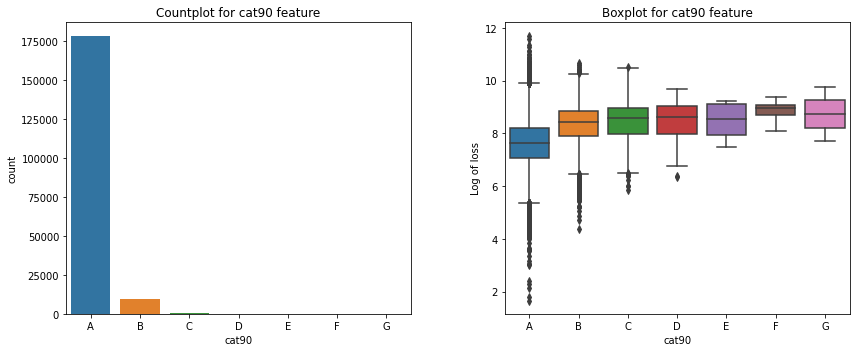

A    177992
B      9515
C       728
D        70
E         6
F         4
G         2
Name: cat90, dtype: int64
Percent of majority category is  94.51722361762347


In [ ]:
categorical_plot('cat90')

* More than 94% of the values belong to category 'A'
* Other categories have few values with G having 2 values
* Distribution of log-loss for all categories is slightly different.
Hence, this feature can add value to the loss prediction.

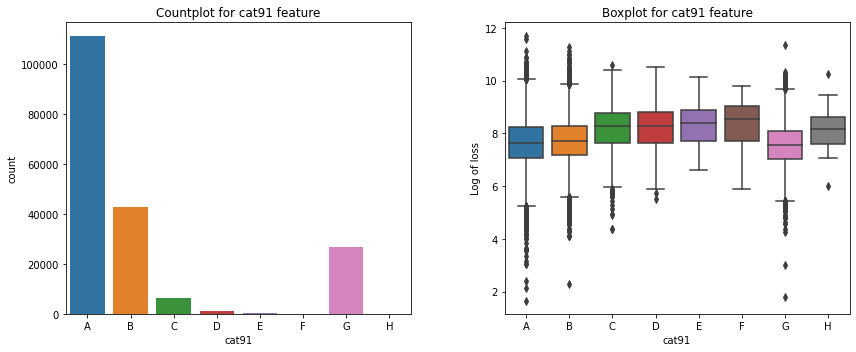

A    111027
B     42630
G     26734
C      6400
D      1149
E       254
F        97
H        26
Name: cat91, dtype: int64
Percent of majority category is  58.957502509067155


In [ ]:
categorical_plot('cat91')

* Data is distributed among all the categories without high majority.
* Distribution of log-loss for all categories is slightly different.Hence, this feature can add value to the loss prediction.

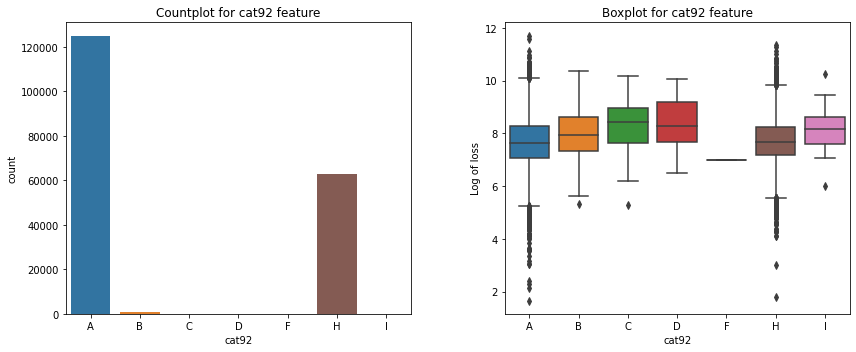

A    124688
H     62901
B       628
C        62
I        26
D        11
F         1
Name: cat92, dtype: int64
Percent of majority category is  66.21175995794326


In [ ]:
categorical_plot('cat92')

* Most of the data is distributed between two categories 'A' and 'H'
* Other categories have few values with F having single value.
* Distribution of log-loss for all categories is different.Hence, this feature can add value to the loss prediction.

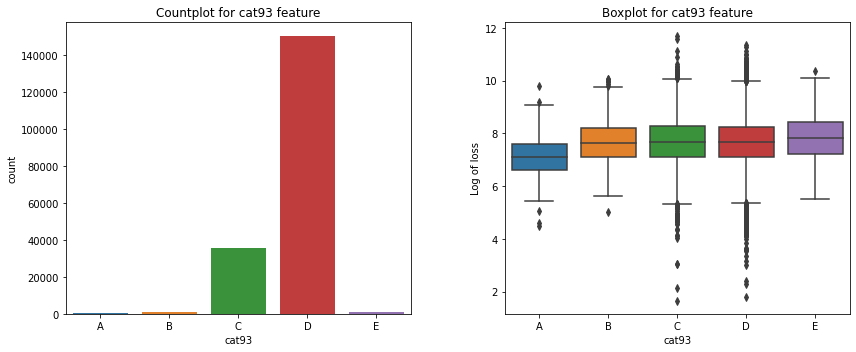

D    150236
C     35788
B      1133
E       728
A       432
Name: cat93, dtype: int64
Percent of majority category is  79.77824625498495


In [ ]:
categorical_plot('cat93')

* Most of the data is distributed between two categories 'C' and 'D'
* Other categories also have few values, more than 400.
* Distribution of log-loss for all categories is slightly different.

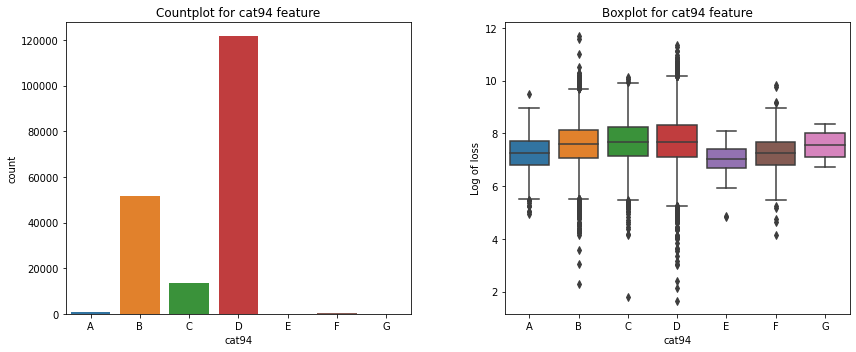

D    121641
B     51710
C     13623
A       738
F       494
E        91
G        20
Name: cat94, dtype: int64
Percent of majority category is  64.5937435281998


In [ ]:
categorical_plot('cat94')

* Most of the data is distributed between three categories 'B','C' and 'D'
* Category D has 64% of values.
* Distribution of log-loss for all categories is different.Hence, this feature can add value to the loss prediction.

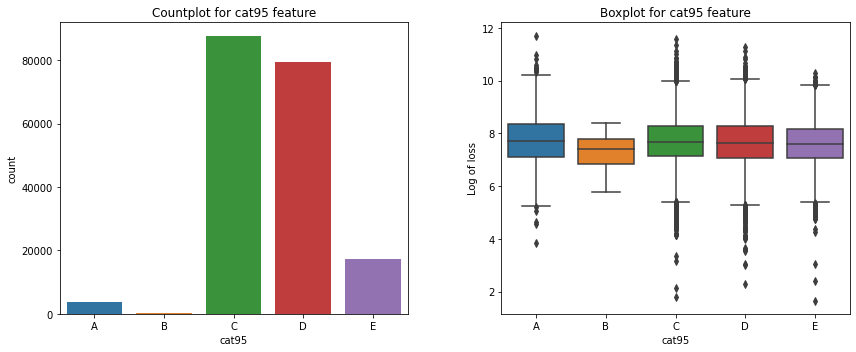

C    87530
D    79525
E    17417
A     3736
B      109
Name: cat95, dtype: int64
Percent of majority category is  46.480137215439925


In [ ]:
categorical_plot('cat95')

* Most of the data is distributed between three categories ','C','D' and 'E'
* Category C has 46% of data.
* Distribution of log-loss for all categories is almost similar to each other.

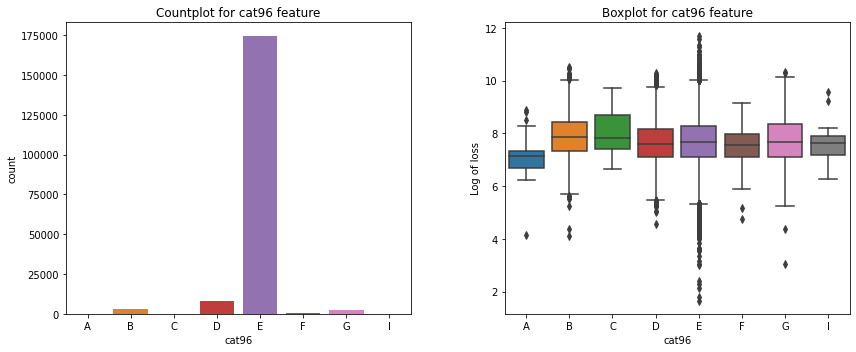

E    174359
D      7922
B      2957
G      2665
F       343
A        35
C        24
I        12
Name: cat96, dtype: int64
Percent of majority category is  92.58802975833302


In [ ]:
categorical_plot('cat96')

* 92% of the data is present in category 'E' 
* D,B and G also have values,greater than 2500
* Distribution of log-loss for all categories is slightly different.

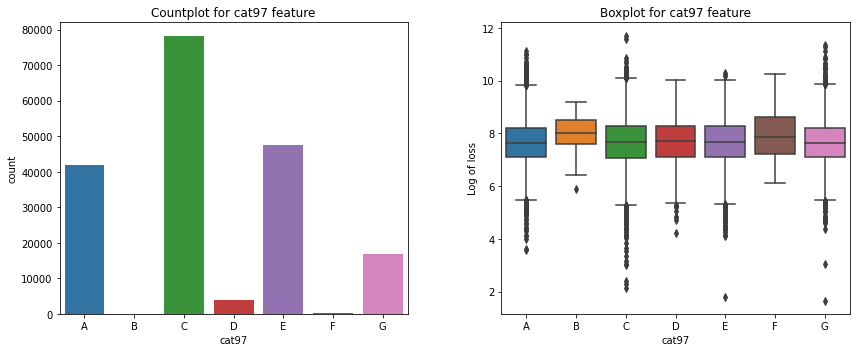

C    78126
E    47450
A    41970
G    16745
D     3779
F      213
B       34
Name: cat97, dtype: int64
Percent of majority category is  41.486429796566426


In [ ]:
categorical_plot('cat97')

* Data is distributed among most of the features
* Category C has highest number of values(41%)
* Distribution of log-loss for all categories is almost similar to each other.

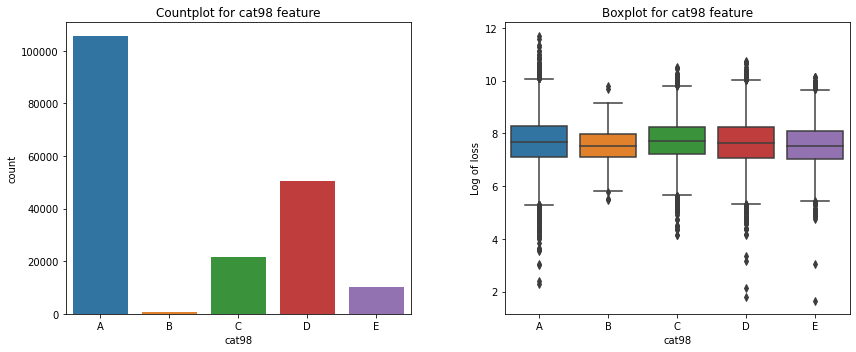

A    105492
D     50556
C     21485
E     10242
B       542
Name: cat98, dtype: int64
Percent of majority category is  56.01830955250986


In [ ]:
categorical_plot('cat98')

* Data is distributed among most of the features
* Category A has highest number of values(56%)
* Distribution of log-loss for all categories is almost similar to each other.

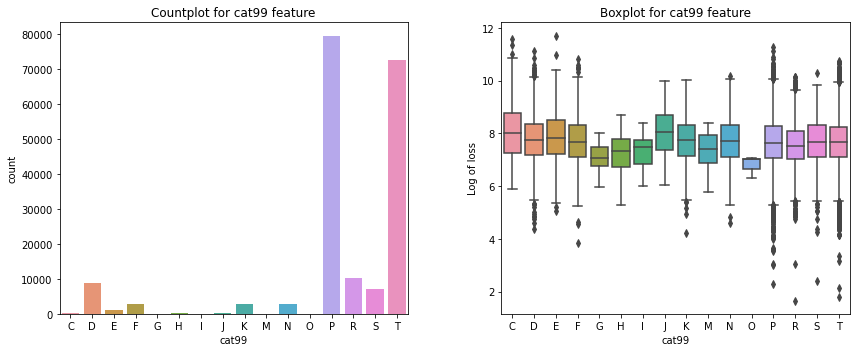

P    79455
T    72590
R    10290
D     8844
S     7045
N     2894
K     2703
F     2702
E     1034
C      310
J      245
H       93
M       52
I       38
G       19
O        3
Name: cat99, dtype: int64
Percent of majority category is  42.19215471784278


In [ ]:
categorical_plot('cat99')

* Most of the data is distributed between two categories 'P' and 'T'
* Category P has highest number of values(42%)
* Distribution of log-loss for all categories is different to each other.Hence, this feature can add value to the loss prediction.

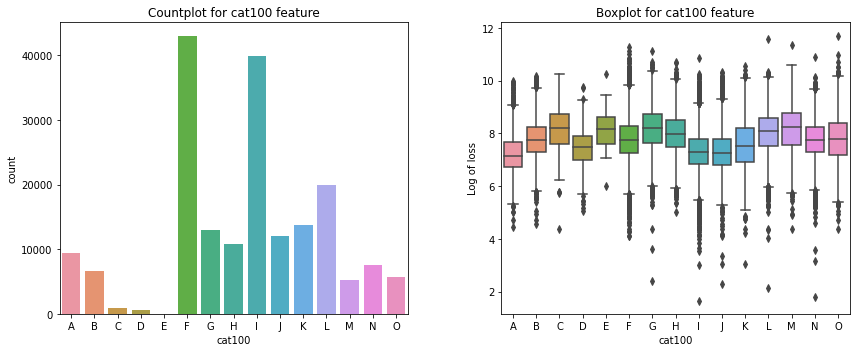

F    42970
I    39932
L    19961
K    13817
G    12935
J    12027
H    10776
A     9402
N     7592
B     6608
O     5697
M     5185
C      836
D      553
E       26
Name: cat100, dtype: int64
Percent of majority category is  22.817908101764576


In [ ]:
categorical_plot('cat100')

* Data is distributed among most of the features
* Category F has highest number of values(22%)
* Distribution of log-loss for all categories is different to each other.Hence, this feature can add value to the loss prediction.

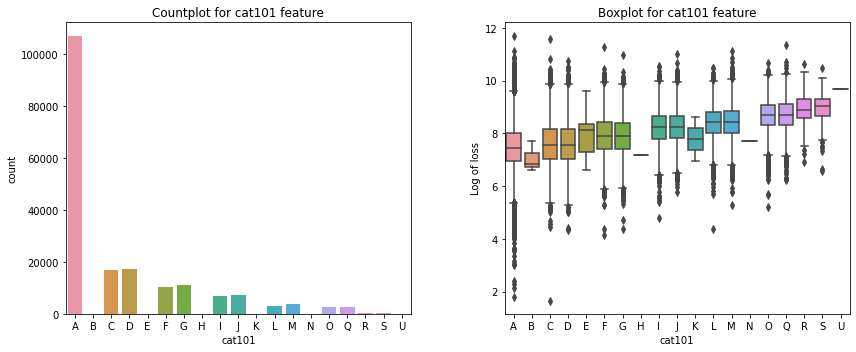

A    106720
D     17171
C     16971
G     10944
F     10139
J      7259
I      6690
M      3669
L      3173
Q      2762
O      2493
S       173
R       138
E         7
B         3
K         2
U         1
H         1
N         1
Name: cat101, dtype: int64
Percent of majority category is  56.67040150384724


In [ ]:
categorical_plot('cat101')

* Data is distributed among most of the features with 'A' having more than 50% of data.
* There are categories like U,H,N which have just one value.
* Distribution of log-loss for all categories is different to each other.Hence, this feature can add value to the loss prediction.

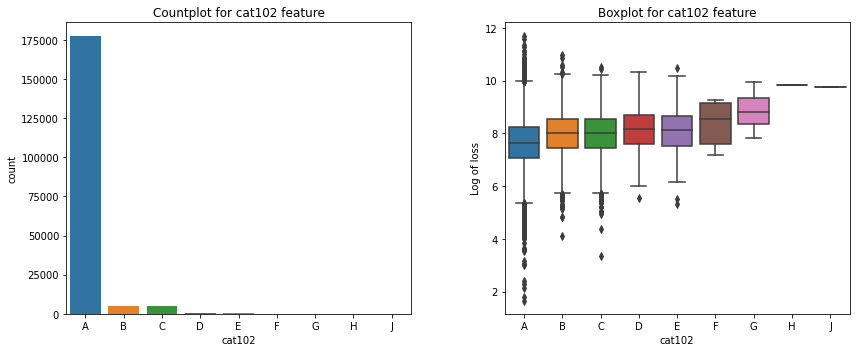

A    177273
B      5155
C      4929
E       482
D       449
G        15
F        12
J         1
H         1
Name: cat102, dtype: int64
Percent of majority category is  94.13542059399842


In [ ]:
categorical_plot('cat102')

* 94% of data is present in Category A.
* Categories like J and H have single values.
* Distribution of log-loss for all categories is slightly different to each other.

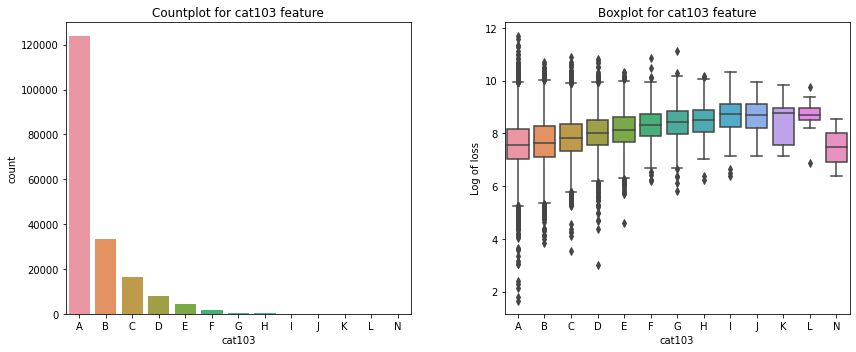

A    123736
B     33342
C     16508
D      7806
E      4473
F      1528
G       550
H       190
I       109
J        45
L        17
K        11
N         2
Name: cat103, dtype: int64
Percent of majority category is  65.70622938980549


In [ ]:
categorical_plot('cat103')

* Data is distributed among most of the features with 'A' having more than 65% of data.
* There are few categories like L,K,N which have very few values.
* Distribution of log-loss for all categories is slightly different to each other.Hence, this feature can add value to the loss prediction.

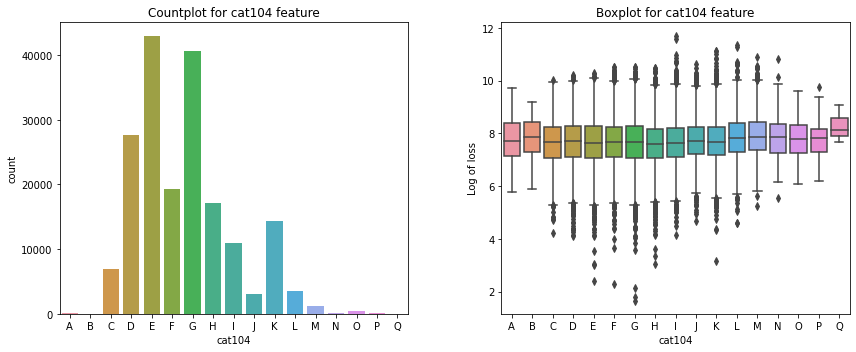

E    42925
G    40659
D    27611
F    19228
H    17187
K    14297
I    10919
C     6949
L     3486
J     3138
M     1156
O      409
N      153
P       86
A       68
B       43
Q        3
Name: cat104, dtype: int64
Percent of majority category is  22.79401222406899


In [ ]:
categorical_plot('cat104')

* Data is distributed among most of the features 
* Category E has highest number of values(22%)
* Distribution of log-loss for all categories is similar to each other.

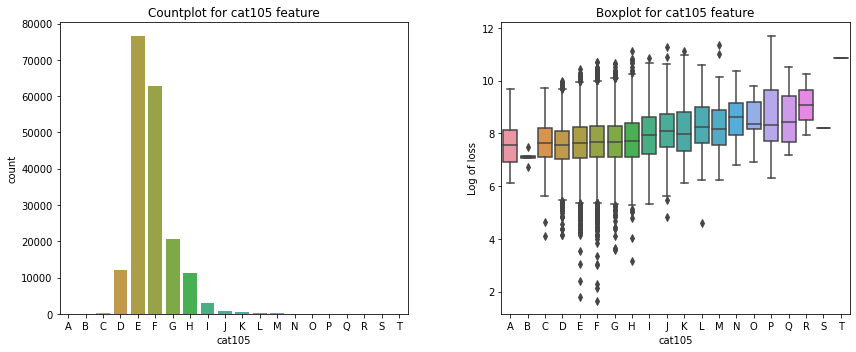

E    76493
F    62891
G    20613
D    12172
H    11258
I     2941
J      694
K      486
C      275
M      171
L      145
A       77
N       64
P       15
O        9
B        5
Q        4
R        2
T        1
S        1
Name: cat105, dtype: int64
Percent of majority category is  40.61927494596877


In [ ]:
categorical_plot('cat105')

* Data is distributed mostly among categories E,F,G,D and H
* There are few categories that have one value like T and S. 
* Distribution of log-loss for all categories is slightly different to each other.Hence, this feature can add value to the loss prediction.

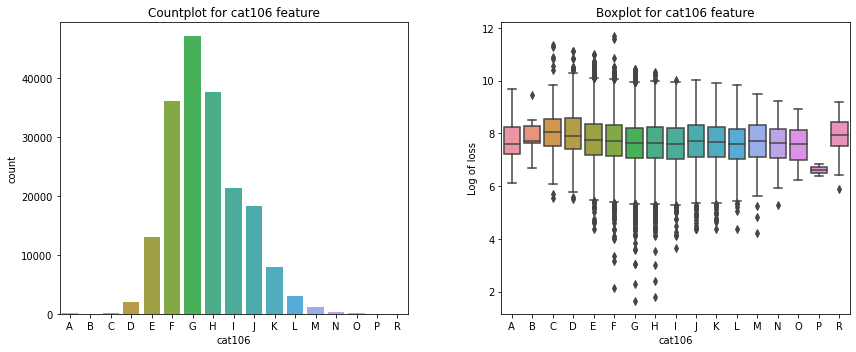

G    47165
H    37713
F    36142
I    21433
J    18281
E    13000
K     7958
L     2971
D     1934
M     1176
N      231
C      129
A       75
O       66
R       32
B        9
P        2
Name: cat106, dtype: int64
Percent of majority category is  25.045534922497705


In [ ]:
categorical_plot('cat106')

* Data is distributed among most of the features
* Category G has highest number of values(25%) 
* Distribution of log-loss for all categories is slightly different to each other.

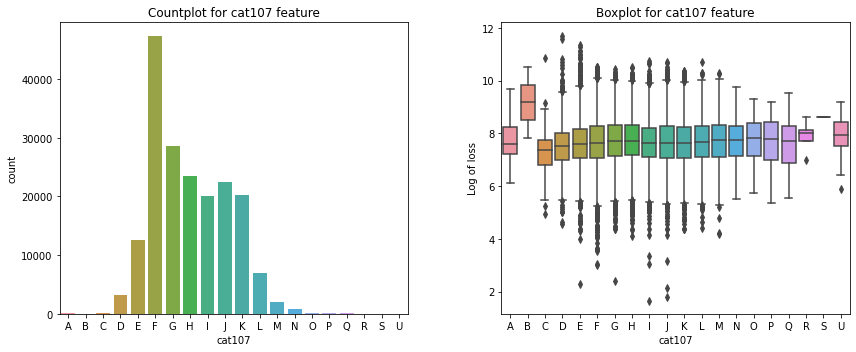

F    47310
G    28560
H    23461
J    22404
K    20236
I    20066
E    12521
L     6976
D     3225
M     2067
N      797
C      213
Q      140
O      125
P      100
A       75
U       32
R        5
S        2
B        2
Name: cat107, dtype: int64
Percent of majority category is  25.12253275062793


In [ ]:
categorical_plot('cat107')

* Data is distributed among most of the features 
* Category F has highest number of values(25%)
* Distribution of log-loss for all categories is slightly different to each other.Hence, this feature can add value to the loss prediction.

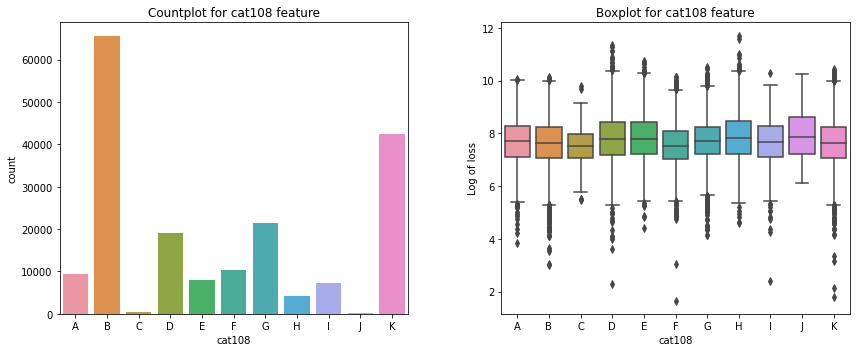

B    65512
K    42434
G    21421
D    19160
F    10242
A     9299
E     7968
I     7243
H     4305
C      520
J      213
Name: cat108, dtype: int64
Percent of majority category is  34.78814976874101


In [ ]:
categorical_plot('cat108')

* Data is distributed among most of the features
* Category B has highest number of values(34%) 
* Distribution of log-loss for all categories is similar to  each other.

In [ ]:
def categorical_plot_higher(col):
  '''Plots countplot and boxplot for categorical features with higher categories'''
  fig,ax=plt.subplots(2,1,figsize=(20,10))
  ax0=sns.countplot(x=col,data=train,order=sorted(train[col].unique()),ax=ax[0])
  ax0.set_title('Countplot for {} feature'.format(col))

  ax1=sns.boxplot(x=col,y=np.log(train['loss']),data=train,order=sorted(train[col].unique()),ax=ax[1])
  ax1.set_ylabel('Log of loss')
  ax1.set_title('Boxplot for {} feature'.format(col))

  plt.tight_layout(h_pad=6)
  plt.show()
  a=train[col].value_counts()
  print(a)
  print('Percent of majority category is ',a.max()*100/a.sum())

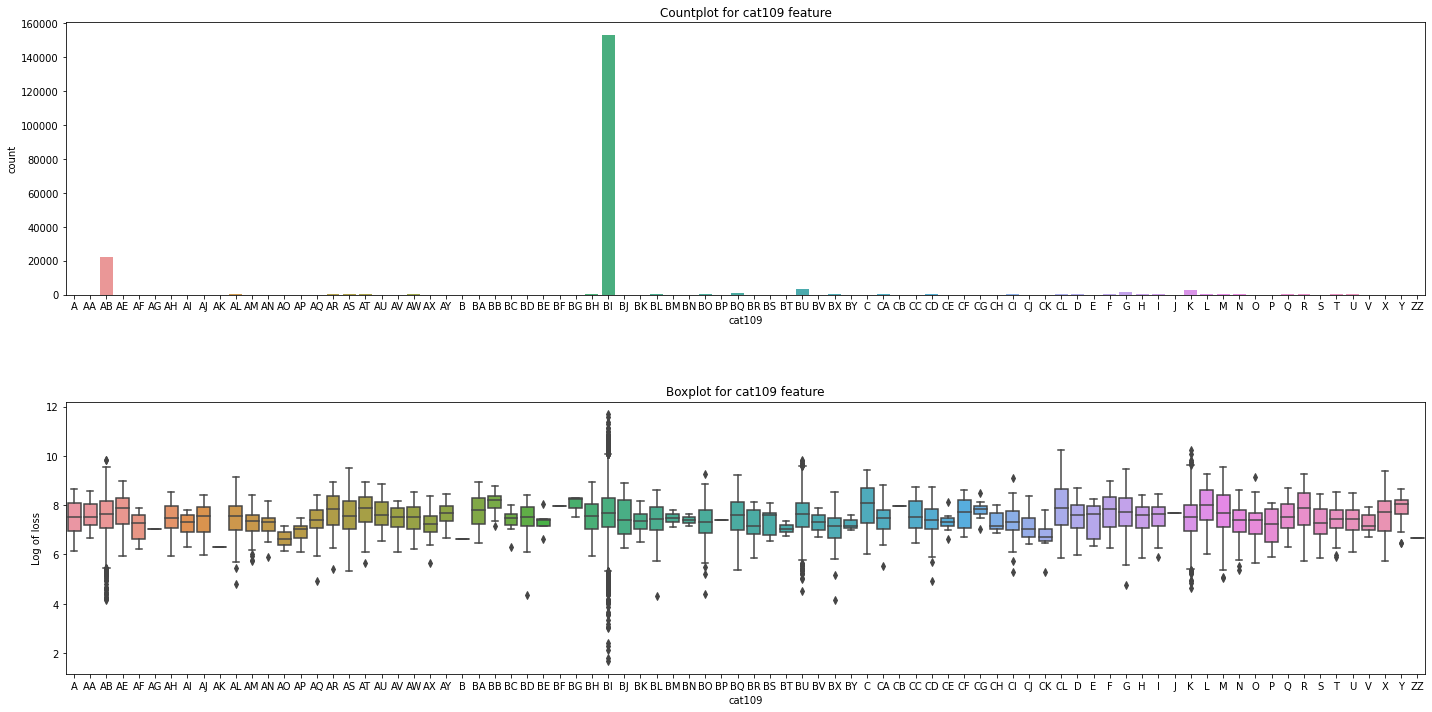

BI    152917
AB     21933
BU      3142
K       2999
G       1353
       ...  
J          1
ZZ         1
AK         1
AG         1
CB         1
Name: cat109, Length: 84, dtype: int64
Percent of majority category is  81.20190954613763


In [ ]:
categorical_plot_higher('cat109')

* Data is distributed among very few features with 'BI' category having 81% of data
* There are many categories that have single values like J,ZZ,AK,AG,CB
* Distribution of log-loss for all categories is slightly different to each other.

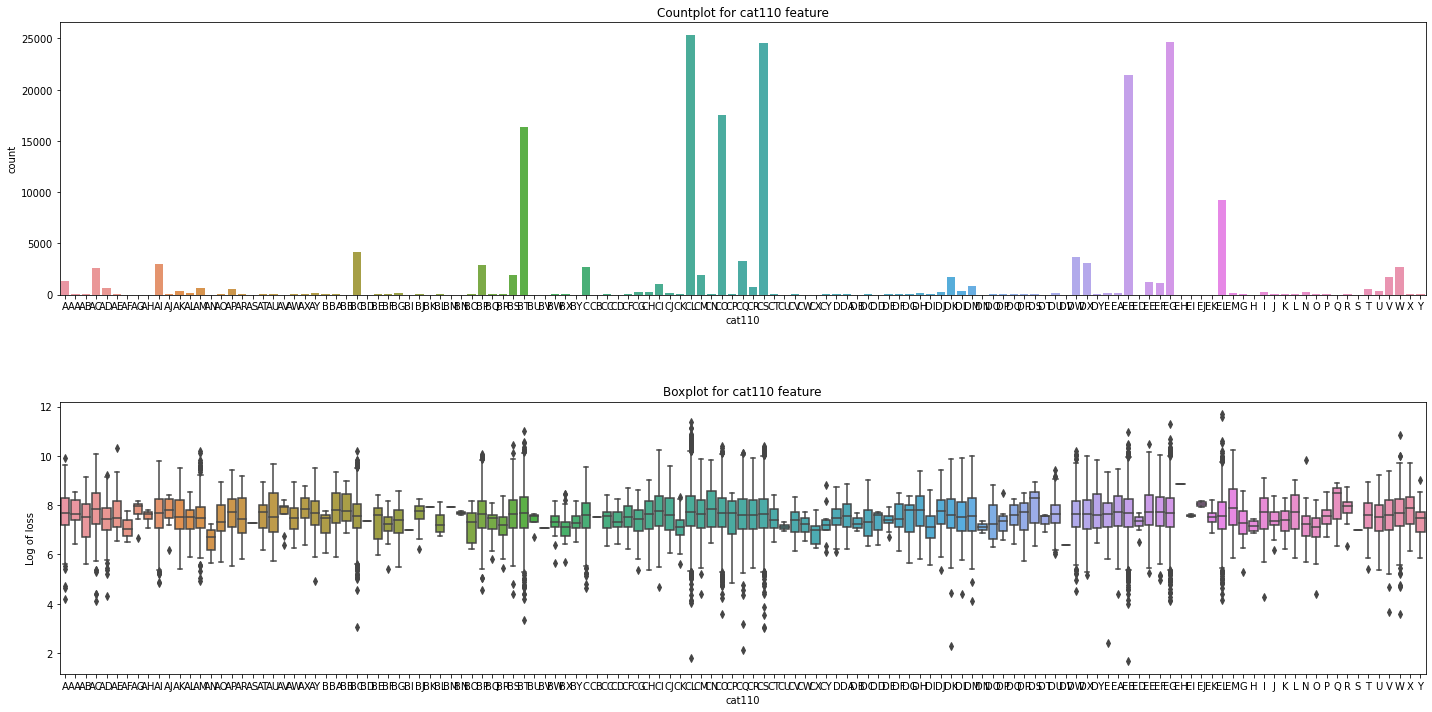

CL    25305
EG    24654
CS    24592
EB    21395
CO    17495
      ...  
BK        1
AS        1
BM        1
S         1
CB        1
Name: cat110, Length: 131, dtype: int64
Percent of majority category is  13.437448557485517


In [ ]:
categorical_plot_higher('cat110')

* This feature has 131 categories
* Data is distributed among many features with CL having 13% of data
* There are categories that have single value like BK,S,CB etc.
* Distribution of log-loss for all categories is slightly different to each other.

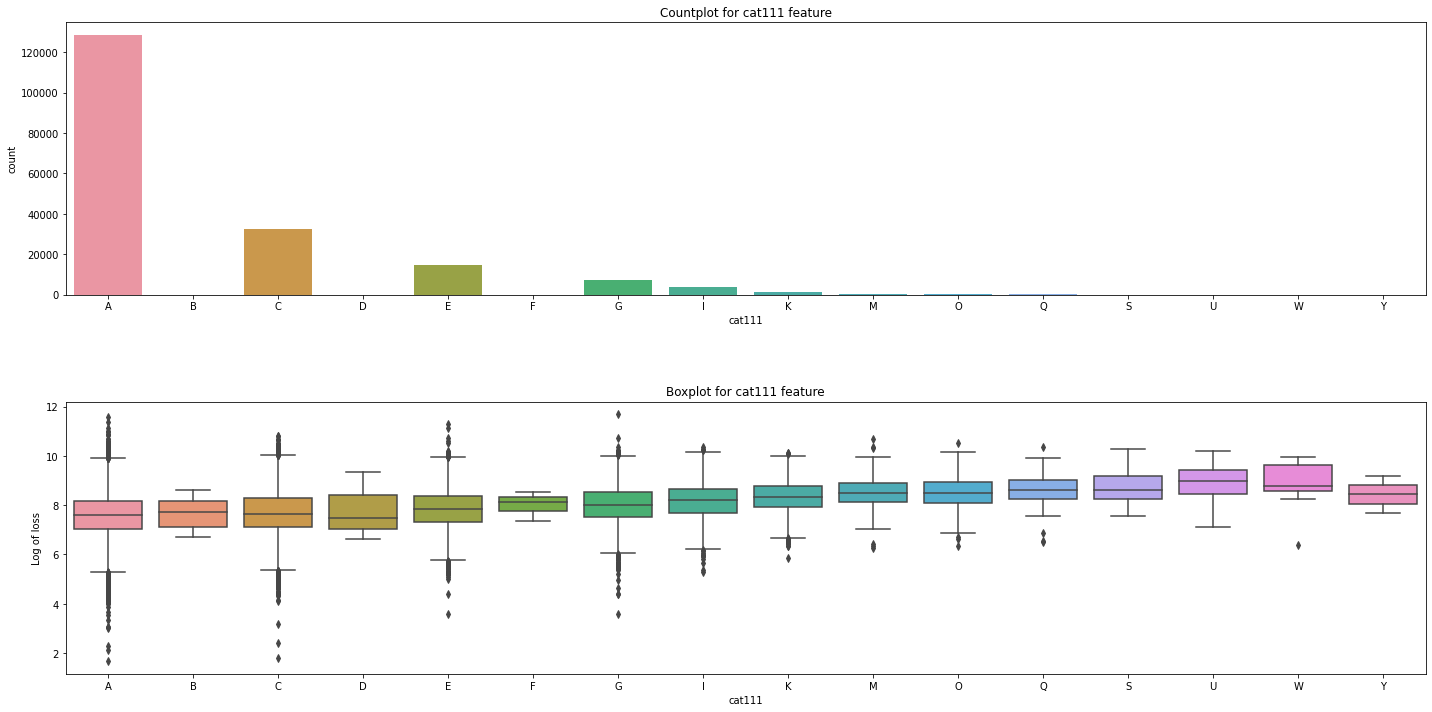

A    128395
C     32400
E     14682
G      7039
I      3578
K      1353
M       473
O       221
Q        91
S        38
W        16
U        16
B         7
D         3
F         3
Y         2
Name: cat111, dtype: int64
Percent of majority category is  68.18024926055534


In [ ]:
categorical_plot_higher('cat111')

* Data is distributed among few categories.
* Category A has highest number of values(68%) 
* Distribution of log-loss for all categories is slightly different to each other.

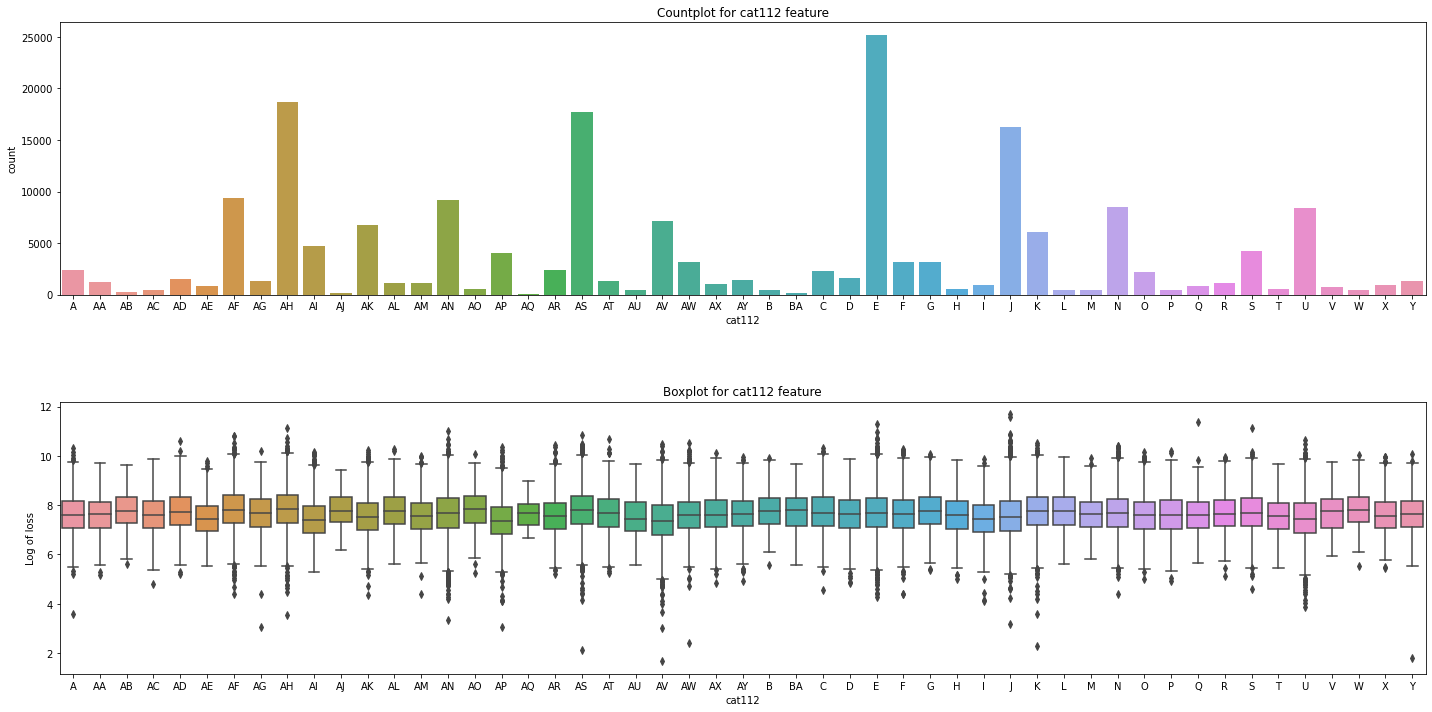

E     25148
AH    18639
AS    17669
J     16222
AF     9368
AN     9138
N      8453
U      8356
AV     7122
AK     6726
K      6059
AI     4749
S      4201
AP     4000
G      3168
F      3149
AW     3145
A      2411
AR     2365
C      2257
O      2183
D      1645
AD     1531
AY     1414
Y      1351
AG     1331
AT     1272
AA     1241
AM     1170
AL     1130
R      1123
AX     1073
I       940
X       925
AE      834
Q       793
V       693
H       548
AO      534
T       521
L       493
W       461
AC      454
M       439
AU      434
B       423
P       406
AB      246
BA      190
AJ      144
AQ       30
Name: cat112, dtype: int64
Percent of majority category is  13.354078495303133


In [ ]:
categorical_plot_higher('cat112')

* Data is distributed among many categories. 
* Category E has highest number of values(13%)
* Distribution of log-loss for all categories is similar to each other.

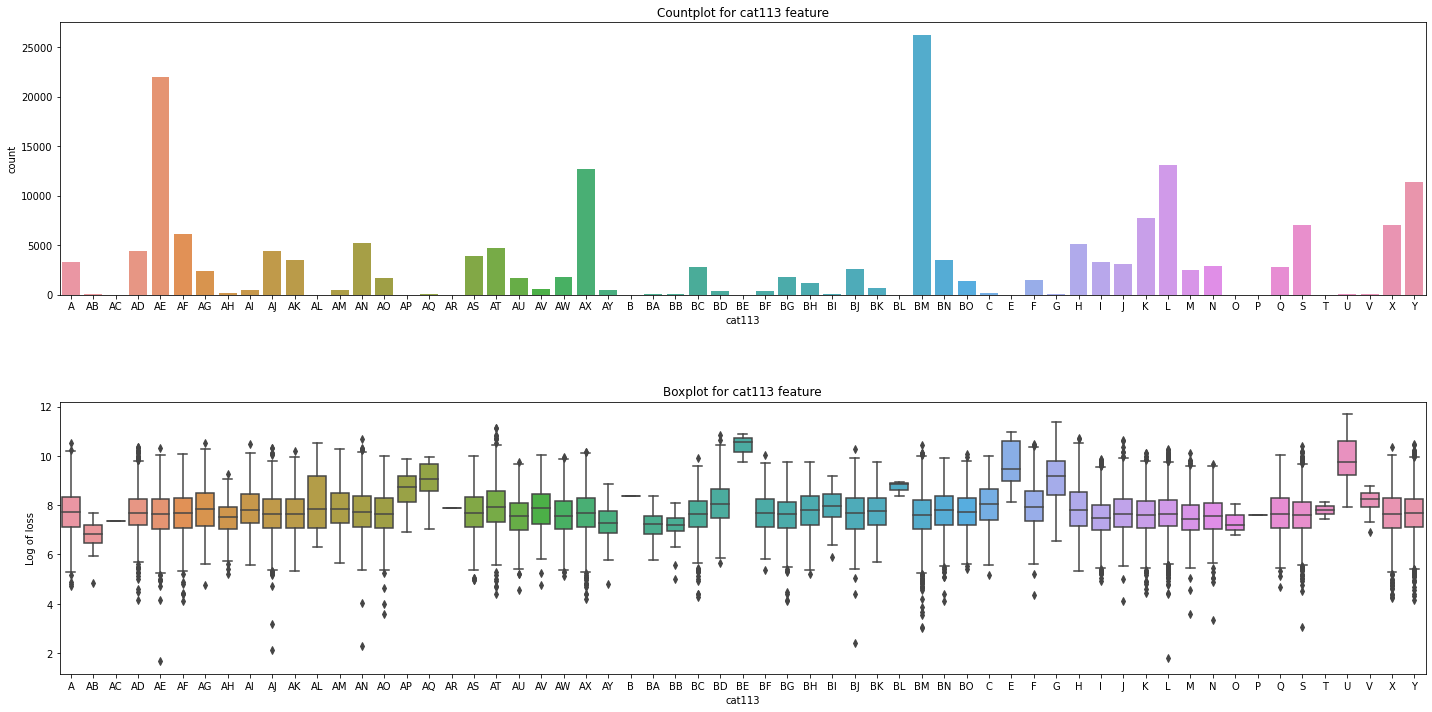

BM    26191
AE    22030
L     13058
AX    12661
Y     11373
      ...  
T         2
AR        1
AC        1
B         1
P         1
Name: cat113, Length: 61, dtype: int64
Percent of majority category is  13.907931838336422


In [ ]:
categorical_plot_higher('cat113')

* This feature has 61 categories
* Data is distributed among many categories.
* Category BM has highest number of values(13%) 
* Distribution of log-loss for all categories is sightly different to each other.

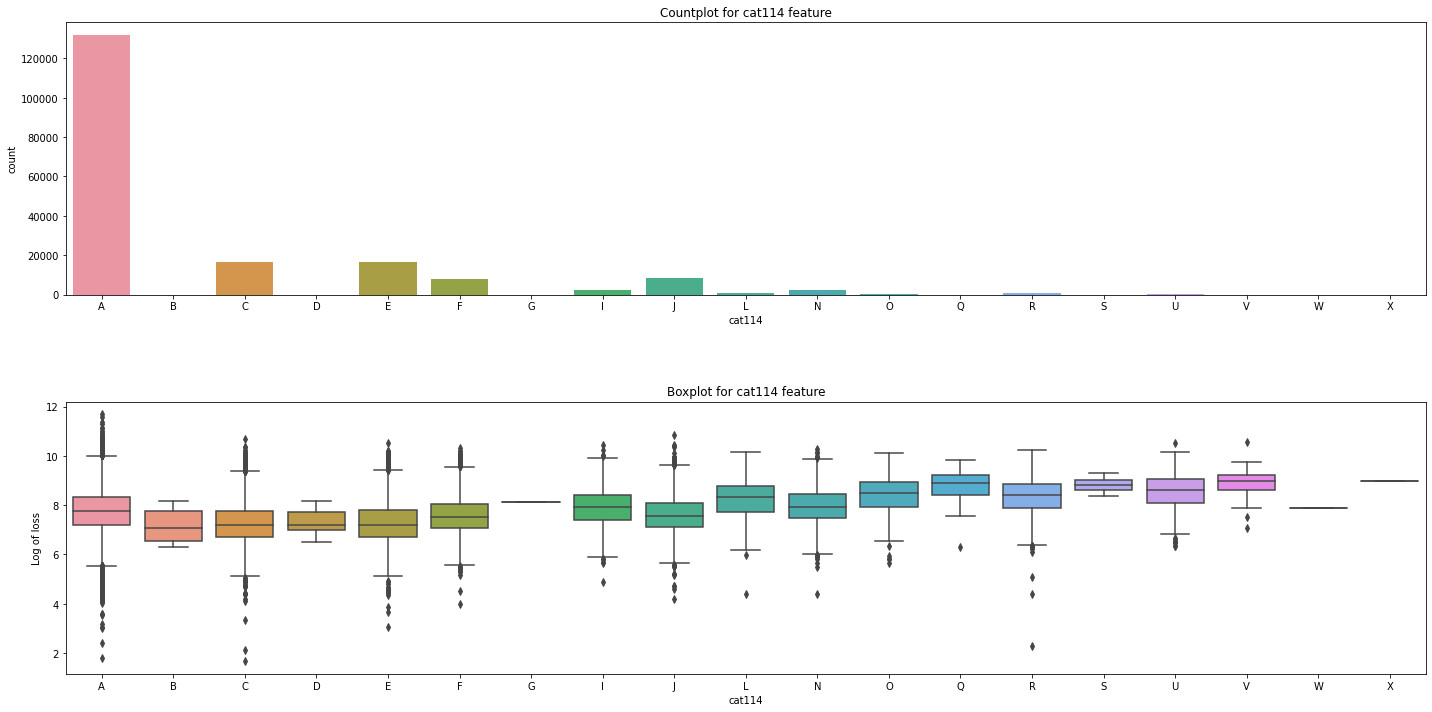

A    131693
C     16793
E     16474
J      8199
F      7905
N      2455
I      2432
R       912
L       870
U       250
O       240
Q        43
V        33
B         6
D         5
S         4
X         1
G         1
W         1
Name: cat114, dtype: int64
Percent of majority category is  69.93155158588975


In [ ]:
categorical_plot_higher('cat114')

* Data is distributed among many categories with category 'A' having 69% of data.
* There are categories that have just one value like X,G,W 
* Distribution of log-loss for all categories is sightly different to each other.

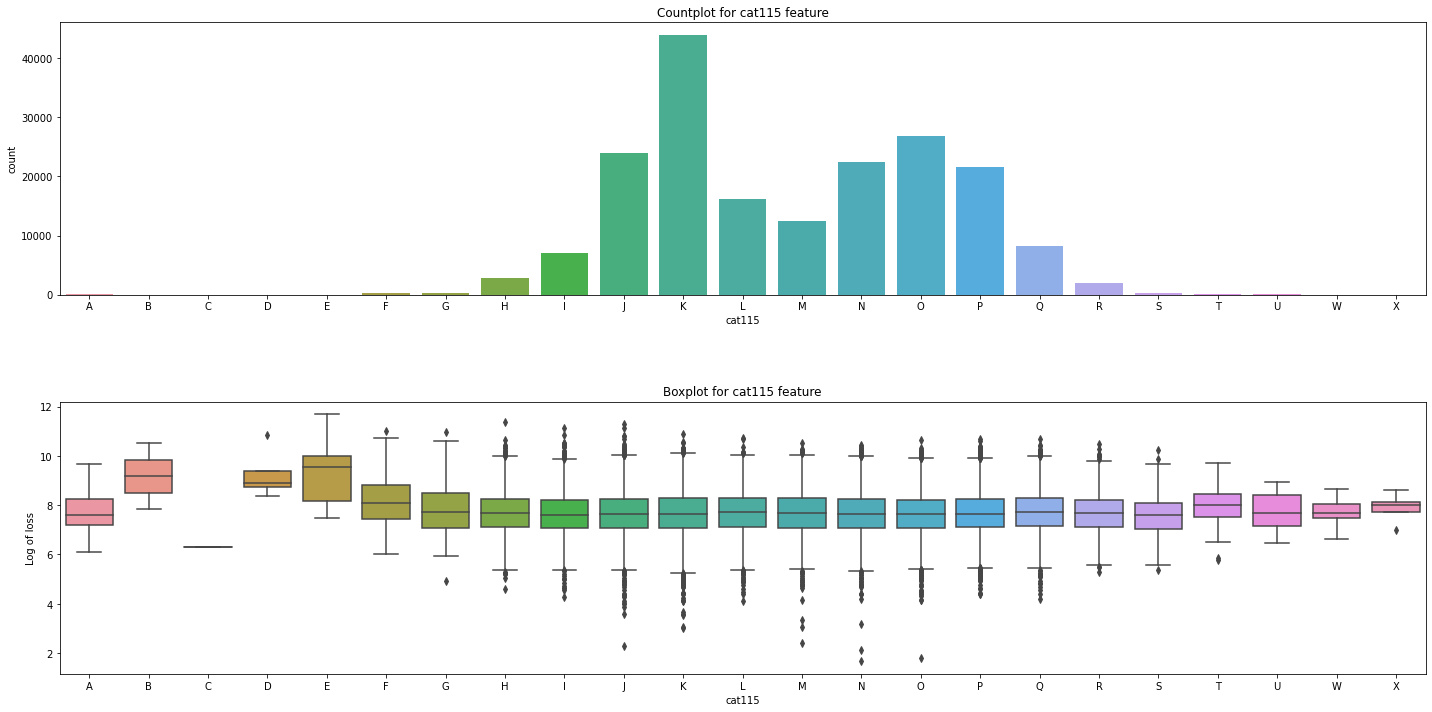

K    43866
O    26813
J    23895
N    22438
P    21538
L    16125
M    12443
Q     8258
I     7090
H     2793
R     2038
G      315
F      269
S      250
A       75
T       56
U       26
E       11
W        6
X        5
D        4
B        2
C        1
Name: cat115, dtype: int64
Percent of majority category is  23.293701577658947


In [ ]:
categorical_plot_higher('cat115')

* Data is distributed among many categories. 
* Category K has highest number of values(23%)
* Distribution of log-loss for all categories is sightly similar to each other.

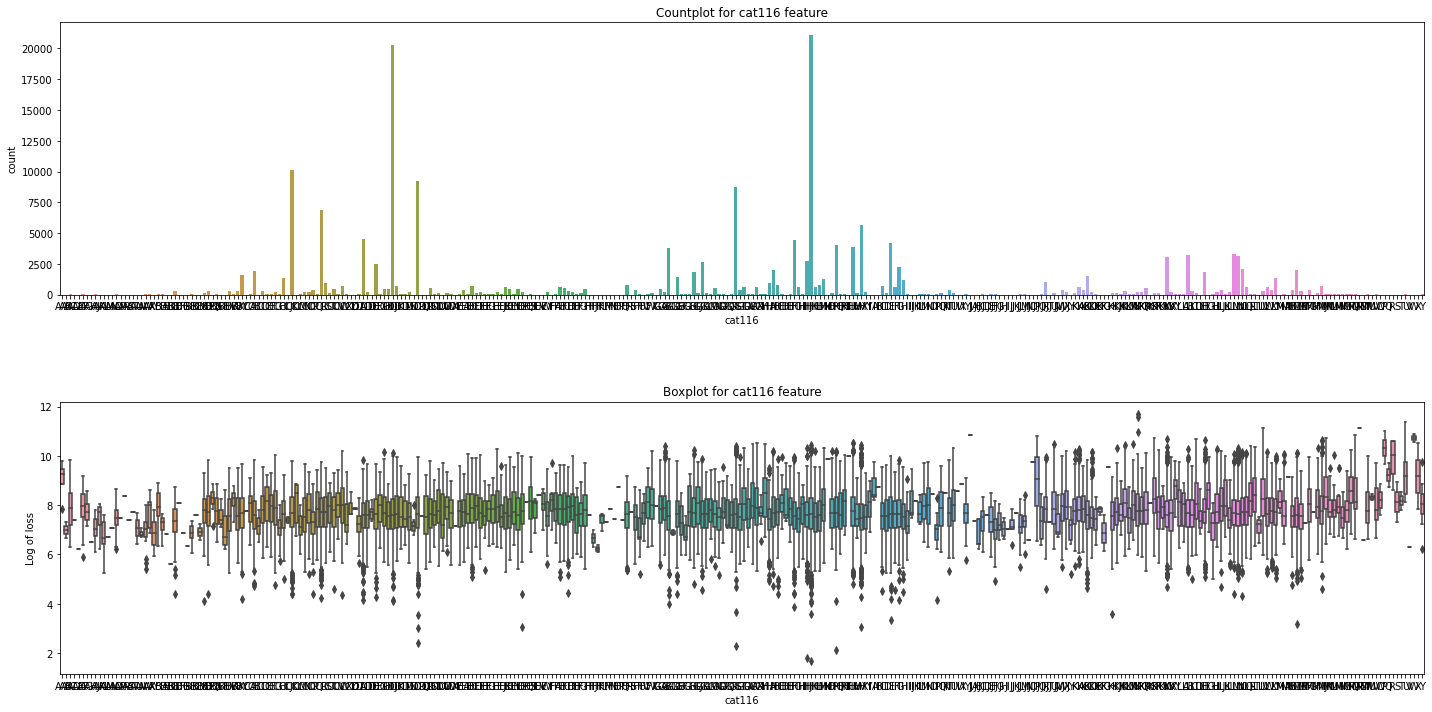

HK    21060
DJ    20244
CK    10162
DP     9202
GS     8736
      ...  
V         1
FS        1
KH        1
G         1
EQ        1
Name: cat116, Length: 326, dtype: int64
Percent of majority category is  11.183270761535072


In [ ]:
categorical_plot_higher('cat116')

* This feature has highest number of categories(326)
* Data is distributed among many categories with HK having the highest(11%).
* There are many categories that have single value like V,FS,G,EQ,etc. 
* Distribution of log-loss for all categories is sightly similar to each other.

### NUMERICAL FEATURES

In [ ]:
#Percentile values of numerical features
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


* All the contineous variables are in the range of 0-1 with mean close to 0.5 and standard deviation around 0.2.

#### UNIVARIATE AND BI-VARIATE ANALYSIS

In [ ]:
def cont_plots(col):
  '''Plots pdf and scatterplot of contineous features'''
  fig,ax=plt.subplots(1,2,figsize=(10,5))

  ax1=sns.distplot(train[col],bins=50,color='b',ax=ax[0])
  ax1.set_ylabel('pdf')
  ax1.set_title('PDF of feature {}'.format(col))

  ax2=sns.scatterplot(train[col],np.log(train['loss']))  
  ax2.set_title('Scatterplot between {} and log of loss'.format(col))
  ax2.set_ylabel('Log of loss')

  plt.tight_layout(w_pad=6)
  plt.show()


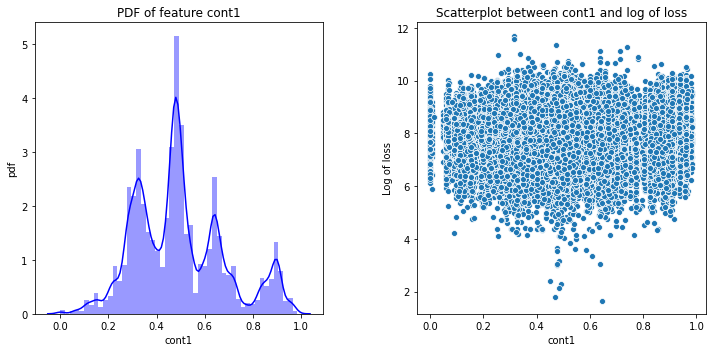

In [ ]:
cont_plots('cont1')

* The pdf has many intermediate peaks with highest peak at 0.5, indicating that many values are present around 0.5.
* There is a small tail on the left side and not much on right.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont1 feature. 

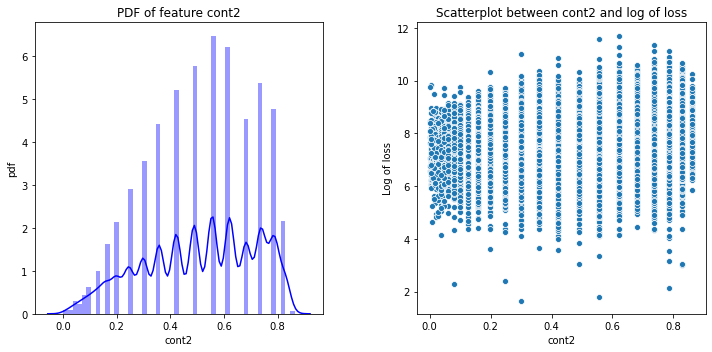

In [ ]:
cont_plots('cont2')

* The pdf has many intermediate peaks with in-between bins completely absent.
* The number of values increases gradually with increase in cont2 values until it reaches around 0.5.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont2 feature.
There are some values above 10 for higher values of cont2. 

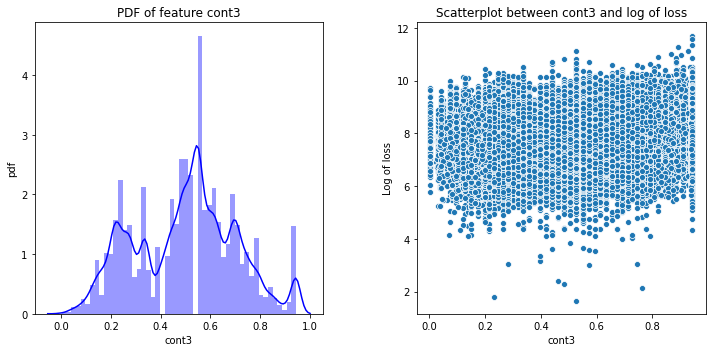

In [ ]:
cont_plots('cont3')

* The pdf has many intermediate peaks with few bins completely absent.
*There is a sharp peak around 0.5 indicating that many values are present around 0.5.
* The scatter plot shows that most of the log of loss value lies between 5 and 10 for different values of cont3 feature.
There are some values above 10 and below 5 for higher values of cont3. 

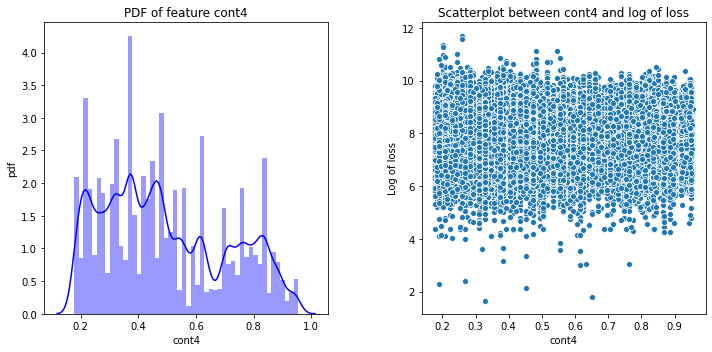

In [ ]:
cont_plots('cont4')

* The pdf has many intermediate peaks.
*There is a sharp peak around 0.4 indicating that many values are present around 0.4.
* The scatter plot shows that most of the log of loss value lies between 5 and 10 for different values of cont4 feature.
 

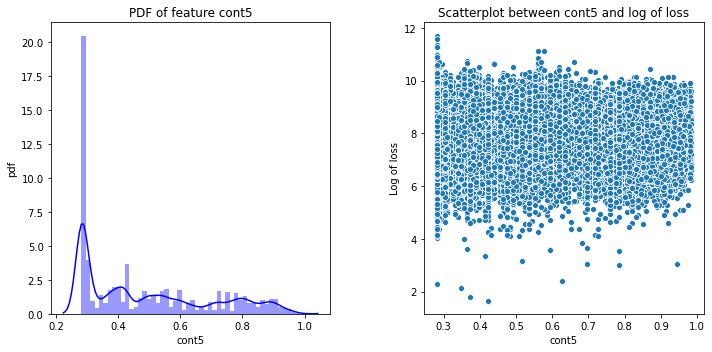

In [ ]:
cont_plots('cont5')

* The pdf has one sharp peaks around 0.3 indicating that many values are present around 0.3.
* As the cont5 value increases the number of values belonging to particular bin decreases.
* The scatter plot shows that most of the log of loss value lies between 5 and 10 for different values of cont5 feature.
There is high loss value for some lower values of cont5
 

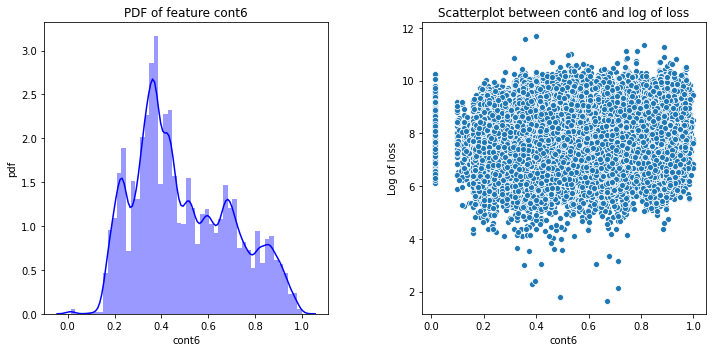

In [ ]:
cont_plots('cont6')

* The pdf has many intermediate peaks.
*There is a sharp peak around 0.3 indicating that many values are present around 0.3.
* The scatter plot shows that most of the log of loss value lies between 5 and 10 for different values of cont6 feature.
* There are no cont6 values around 0.1, which is shown by a minor gap in scatterplot.
 

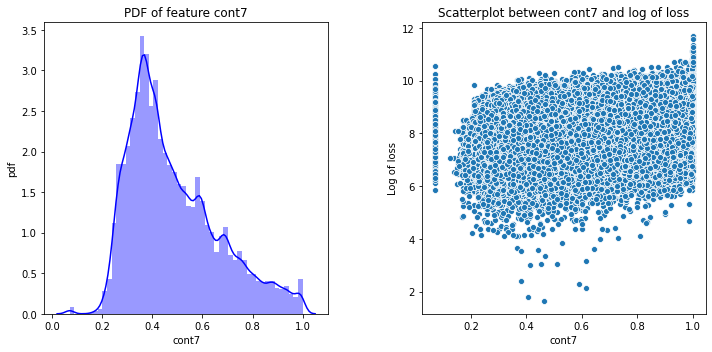

In [ ]:
cont_plots('cont7')

* There is a sharp peak around 0.4 indicating that many values are present around 0.4.
* As the cont7 value increases, the number of values present in the bin decreases gradually after peak at 0.4.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont7 feature.
* There are no cont7 values around 0.1, which is shown by a minor gap in scatterplot
 

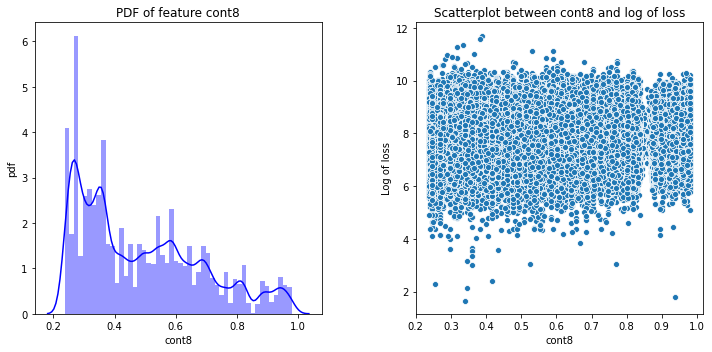

In [ ]:
cont_plots('cont8')

* There is a sharp peak around 0.3 indicating that many values are present around 0.4.
* As the cont8 value increases, the number of values present in the bin decreases gradually after peak at 0.3.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont8 feature.

 

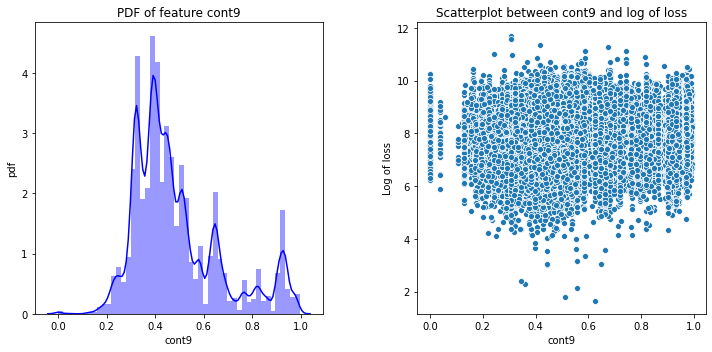

In [ ]:
cont_plots('cont9')

* The pdf has many intermediate peaks.
* There is a sharp peak around 0.4 indicating that many values are present around 0.4.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont9 feature.
* There are no cont9 values around 0.1, which is shown by a minor gap in scatterplot
 

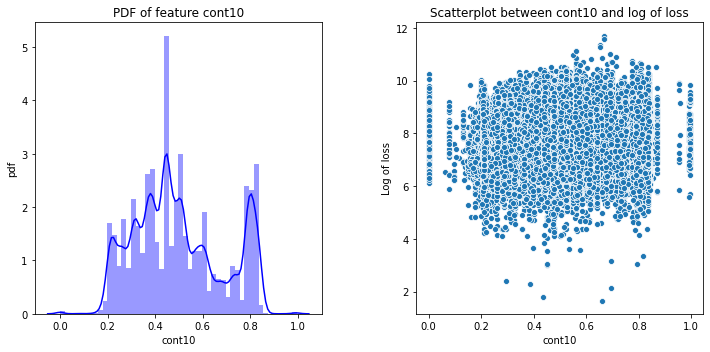

In [ ]:
cont_plots('cont10')

* The pdf has many intermediate peaks.
* There is a sharp peak around 0.4 indicating that many values are present around 0.4.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont10 feature.
* There are no con10 values around 0.1 and 0.9, which is shown by a minor gap in scatterplot
 

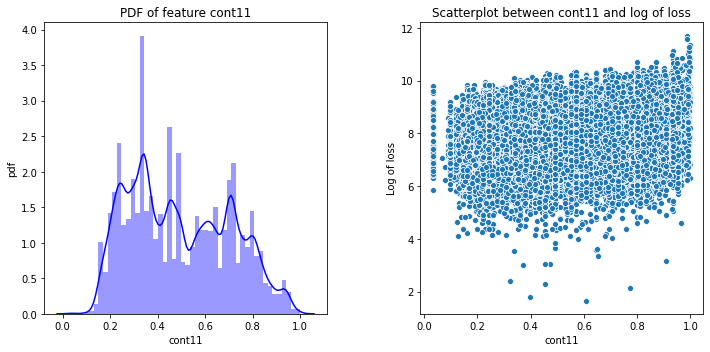

In [ ]:
cont_plots('cont11')

* The pdf has many intermediate peaks.
* There is a sharp peak around 0.3 indicating that many values are present around 0.3.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont11 feature.
* There are higher values of log of loss(11) for higher values of con11
* There are no con11 values around 0.1, which is shown by a minor gap in scatterplot
 

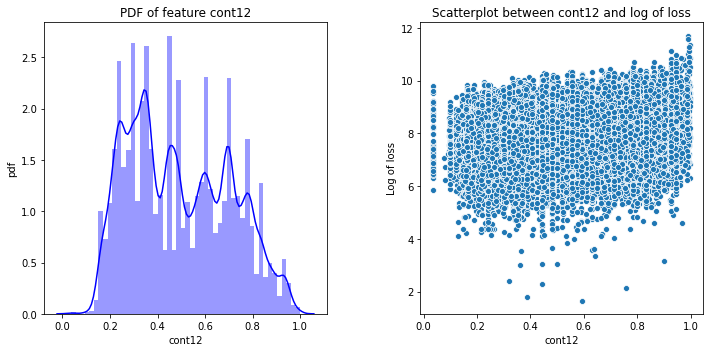

In [ ]:
cont_plots('cont12')

* The pdf has many intermediate peaks.
* There is a sharp peak around 0.3 indicating that many values are present around 0.3.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont12 feature.
* There are higher values of log of loss(11) for higher values of con12
* There are no con12 values around 0.1, which is shown by a minor gap in scatterplot
 

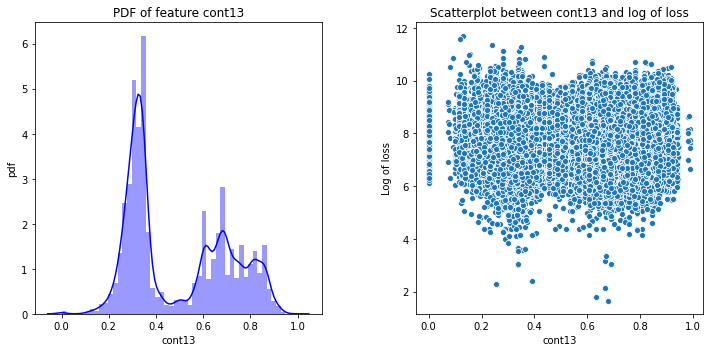

In [ ]:
cont_plots('cont13')

* There is a sharp peak around 0.3 indicating that many values are present around 0.3.
* The scatter plot shows that most of the log of loss value lies between 4 and 10 for different values of cont13 feature.
* There are higher values of log of loss(11) for lower values of con13
* There are no con13 values around 0.1, which is shown by a minor gap in scatterplot
 

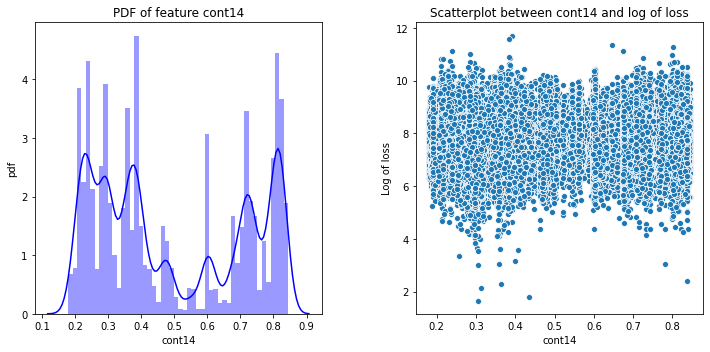

In [ ]:
cont_plots('cont14')

* The pdf has many intermediate peaks.
* The scatter plot shows that most of the log of loss value lies between 5 and 10 for different values of cont14 feature.
* There are lower values of log of loss(less than 3) for lower values of con14

 

#### COLLINEARITY BETWEEN TWO NUMERICAL FEATURES


Text(114.0, 0.5, 'Numerical Features')

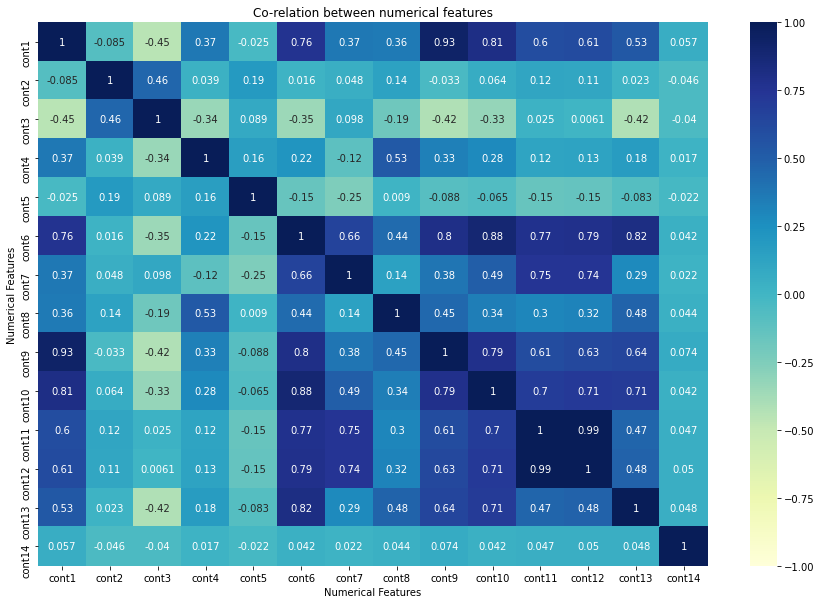

In [ ]:
#Finding the corelated features
count_columns=[i for i in train.columns if 'cont' in i]
plt.subplots(figsize=(15,10))
cor_matrix=train[count_columns].corr()
ax=sns.heatmap(cor_matrix,annot=True,vmin=-1, vmax=1,center=0, cmap="YlGnBu")
ax.set_title('Co-relation between numerical features')
ax.set_xlabel('Numerical Features')
ax.set_ylabel('Numerical Features')


* Pearson's corelation co-efficient is used to find the linear relationship between numerical features.
* There are features that are highly positively co-related like cont1 and cont9 that have Person's value of 0.93
* There are few negatively corelated features like cont1 and cont3(-0.45) but are of low value.
* Since, highly corelated features offer similar information to the model, one of the corelated features can be removed

In [ ]:
#Finding correlated features whose value is greater than 0.9
correlated_features={}
for i in cor_matrix.columns:
  x=list(cor_matrix[cor_matrix[i]>0.9].index)
  x.remove(i)
  correlated_features[i]=x
duplicate=[]
for k,v in correlated_features.items():
  if(len(v)!=0):
    duplicate.append(v[0])  
    if( k not in duplicate):
      print(k+' and '+v[0]+' are corelated')



cont1 and cont9 are corelated
cont11 and cont12 are corelated


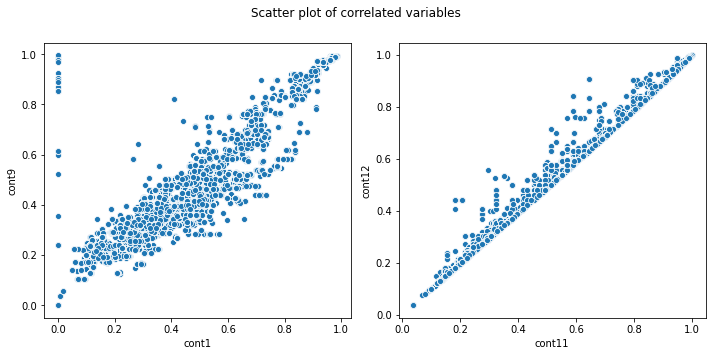

In [ ]:
#Plotting the correlated features

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax=ax.flatten()
sns.scatterplot(train['cont1'],train['cont9'],ax=ax[0])
sns.scatterplot(train['cont11'],train['cont12'],ax=ax[1])
plt.suptitle('Scatter plot of correlated variables')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

* cont1 and cont9 are highly positively corelated with Pearson's value of 0.93. It is clearly evident that as cont1 increases cont9 also increases.
*  cont11 and cont12 are also highly positively corelated with Pearson's value of 0.99. It is clearly evident that as cont11 increases cont12 also increases.

#### MULTI-COLLINEARITY FOR NUMERICAL FEATURES

In [ ]:
#Remove features having high VIF values iteratively
from statsmodels.stats.outliers_influence import variance_inflation_factor

train_multi=train[cont_cols].copy()
train_multi=train_multi.values
multi_cols=cont_cols.copy()

def multi_collinearity(input,cols):
  '''Creates a dataframe with VIF value for different features '''
  df_multi=pd.DataFrame(columns=['Feature','VIF'])
  for i in range(len(cols)):
    df_multi.loc[i,'Feature']=cols[i]
    df_multi.loc[i,'VIF']=variance_inflation_factor(input,i)
  return df_multi

In [ ]:
#Iteration1
df_multi=multi_collinearity(train_multi,multi_cols)
df_multi.sort_values('VIF')

,Feature,VIF
13,cont14,5.5804
4,cont5,7.2981
1,cont2,10.7248
3,cont4,11.0835
2,cont3,14.1234
7,cont8,14.544
6,cont7,30.4489
12,cont13,35.1736
9,cont10,57.3396
8,cont9,88.695


* cont12 has highest VIF value and hence, removing cont12 feature

In [ ]:
#Iteration2
train_multi1=np.delete(train_multi,11,axis=1)
multi_cols.remove('cont12')
df_multi1=multi_collinearity(train_multi1,multi_cols)


In [ ]:
merge_df=pd.merge(df_multi,df_multi1,on='Feature',suffixes=('_0','_1'))
merge_df.sort_values('VIF_1')

,Feature,VIF_0,VIF_1
12,cont14,5.5804,5.57961
4,cont5,7.2981,7.29033
1,cont2,10.7248,10.6818
3,cont4,11.0835,11.0549
2,cont3,14.1234,14.1232
7,cont8,14.544,14.4475
10,cont11,622.424,26.4959
6,cont7,30.4489,30.3948
11,cont13,35.1736,34.9802
9,cont10,57.3396,57.3392


* VIF value of cont11 reduced to 26.49 from 622.63 after removal of cont12, indicating they are higly corelated to each other
* There isn't much change in VIF value for other features.
* Removing cont6 as it has the highest VIF value.

In [ ]:
#Iteration3
train_multi2=np.delete(train_multi1,5,axis=1)
multi_cols.remove('cont6')
df_multi2=multi_collinearity(train_multi2,multi_cols)


In [ ]:
merge_df1=pd.merge(df_multi1,df_multi2,on='Feature',suffixes=('_1','_2'))
merge_df1.sort_values('VIF_2')

,Feature,VIF_1,VIF_2
11,cont14,5.57961,5.45867
4,cont5,7.29033,7.24122
1,cont2,10.6818,10.6772
3,cont4,11.0549,11.0407
2,cont3,14.1232,11.5122
6,cont8,14.4475,14.3841
5,cont7,30.3948,18.8887
10,cont13,34.9802,19.8274
9,cont11,26.4959,23.2224
8,cont10,57.3392,47.7259


* VIF value of cont10 reduced to 47.72 from 57.33,cont7 to 18.8 from 30.3,cont13 to 19.8 from 34.9 after removal of cont6, indicating they are higly corelated to each other
* There is small change in VIF value for other features.
* Removing cont1 as it has the highest VIF value.

In [ ]:
#Iteration4
train_multi3=np.delete(train_multi2,0,axis=1)
multi_cols.remove('cont1')
df_multi3=multi_collinearity(train_multi3,multi_cols)


In [ ]:
merge_df2=pd.merge(df_multi2,df_multi3,on='Feature',suffixes=('_2','_3'))
merge_df2.sort_values('VIF_3')

,Feature,VIF_2,VIF_3
10,cont14,5.45867,5.45314
3,cont5,7.24122,6.79097
0,cont2,10.6772,10.4758
2,cont4,11.0407,10.7512
1,cont3,11.5122,11.3643
5,cont8,14.3841,14.2932
9,cont13,19.8274,16.843
4,cont7,18.8887,18.8701
8,cont11,23.2224,23.2168
6,cont9,87.8403,25.4085


* VIF value of cont9 reduced to 87.8 from 25.4 after removal of cont1, indicating they are higly corelated to each other
* There isn't much change in VIF value for other features.


# Data Preprocessing

In [ ]:
#Lexical Encoding of Categorical features
#Ref: https://www.kaggle.com/modkzs/lexical-encoding-feature-comb


def lex_encode(ch):
  '''LexicalEncoding:Eg:AC=1*26^1+3*26^0=29'''
  l=len(ch)
  total=0
  for i in range(l):
    total+=(ord(ch[i])-ord('A')+1)*26**(l-i-1)
  return total

def lexical_encoding(train):
  '''Converts categories to its corresponding lexical values '''
  cat_cols=[i for i in train.columns if 'cat' in i]
  for feature in cat_cols :
   train[feature]=train[feature].apply(lex_encode)   
  return train



* Label encoding or Ordinal Encoding is not possible as there are few categories that are present in test data and not in train data.
* Merging train and test data before Encoding would cause data leakage.
* Therefore lexical encoding is used 
Eg:AC=1X26^1+3X26^0=29

In [ ]:
#Lexical encoding of train and test data
new_train=lexical_encoding(train)
new_test=lexical_encoding(test)

In [ ]:
#Creating X-train,y_train and X-test dataset
drop_features=['cat15', 'cat22', 'cat55', 'cat56', 'cat62', 'cat63', 'cat64', 'cat68', 'cat70'] 
              
X_train=new_train.drop(['id','loss'],axis=1)
X_train=X_train.drop(drop_features,axis=1)
y_train=np.log(new_train['loss'])

id=new_test['id']
X_test=new_test.drop('id',axis=1)
X_test=X_test.drop(drop_features,axis=1)

print('The shape of train data ',X_train.shape,y_train.shape)
print('The shape of test data ',X_test.shape)

The shape of train data  (188318, 121) (188318,)
The shape of test data  (125546, 121)


### SUMMARY
* Analysis of Target variable: Target variable was highly skewed. Therefore, log transform was performed.
* Checking whether train and test are from same distribution:
Built a Logistic Regression model with train data having '1' class label and test data with '0'. The model was not able to differentiate between train and test data, indicating they are from same distribution.
* Analysis of Categorical features:
  *   Univariate Analysis: Number of datapoints in each category was determined and features having more than 99% of data in a single category was dropped as they don't add much value
  *   Bi-Variate Analysis: Distribution of loss value for different categories in each feature was determined using box-plot.
* Analysis of Numerical features:
  * Univariate Analysis: PDF plot of each numerical feature was plotted. Many plots showed intermediate peaks with tailed distribution
  * Bi-variate Analysis: Scatter plot between loss and each numerical feature was plotted. Most of the features had log of loss between 4 and 10.
  * Collinearity between two numerical features: Pearson's corelation coefficient was used to find collinearity. Two pairs of features had corelation value greater than 0.9. 
  * Multi-collinearity: Variance Inflation Factor(VIF) was used to check for multi-collinearity.VIF test was conducted iteratively with high valued feature removed in next iteration. The results were similar to that of Pearson's co-relation value.
 
* Data Pre-processing:    
    * Categorical Features: Each categorical feature has alphabetical categories. They are subjected to lexical encoding.Eg:AC=1\*26\^1+3\*26\^0=29



   



